# PRCP- 1001- RiceLeaf disease detection

## BUSINESS CASE

To Create a model which can classify the three major attacking diseases of rice plants 
like leaf blast, bacterial blight and brown spot.

In [1]:
#importing required Libraries
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow.keras import layers , models
from tensorflow.keras.models import Sequential
#importing the Convolution Layer 2d 
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,Flatten
import warnings
warnings.filterswarnings=('ignore')

In [2]:
#loading the dataset
data=tf.keras.preprocessing.image_dataset_from_directory(r"C:\Users\user\Downloads\CAPSTONE PROJECT\RICELEAF\Data")                                                   

Found 119 files belonging to 3 classes.


In [3]:
classes=data.class_names
classes

['Bacterial leaf blight', 'Brown spot', 'Leaf smut']

### Data Visualization

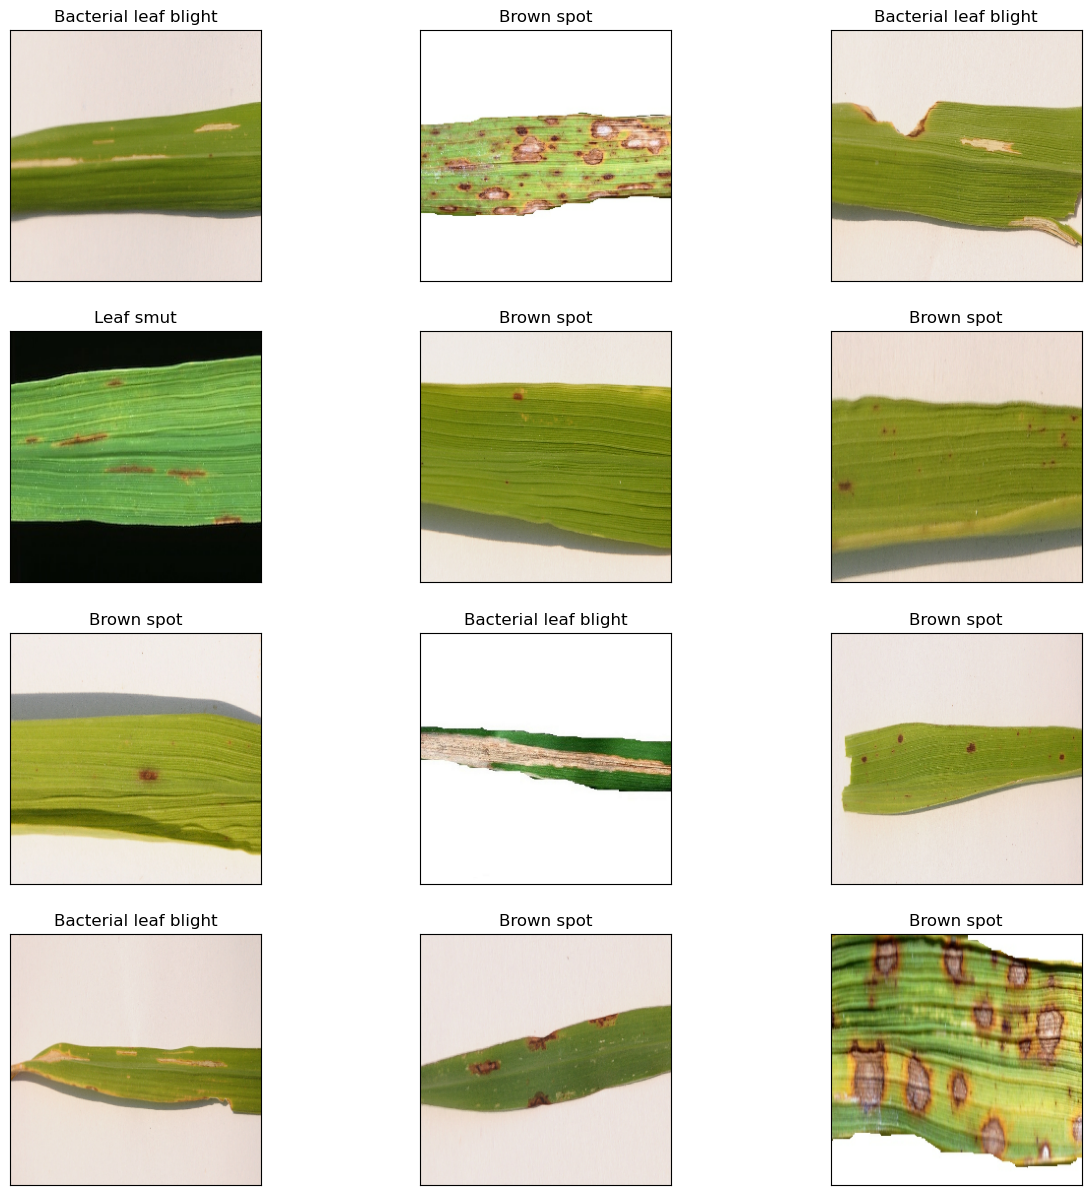

In [4]:
plt.figure(figsize=(15, 15))
for image_batch, labels_batch in data.take(10):
    for i in range(12):
        ax = plt.subplot(4,3, i + 1, xticks=[],yticks=[])
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(classes[labels_batch[i]])

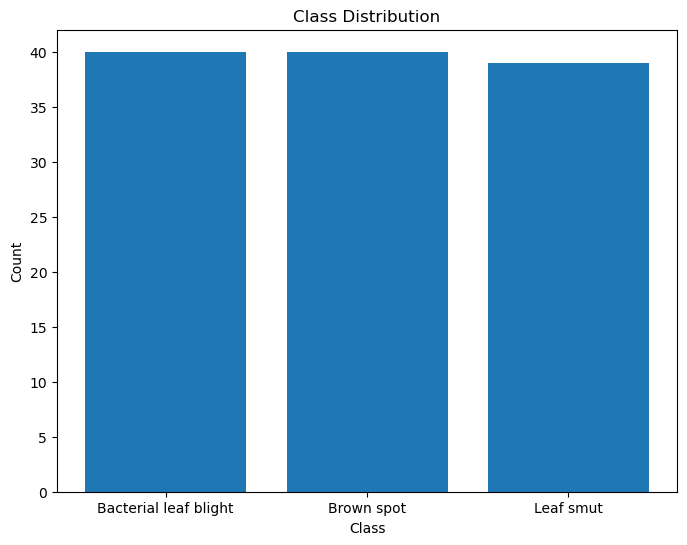

In [5]:
# Get the class names from the dataset
class_names = data.class_names

# Initialize a dictionary to count occurrences of each class
class_counts = {class_name: 0 for class_name in class_names}

# Count occurrences of each class label
for _, labels_batch in data:
    for label in labels_batch.numpy():
        class_counts[class_names[label]] += 1

# Plot the class distribution
plt.figure(figsize=(8, 6))
plt.bar(class_counts.keys(), class_counts.values())
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')

plt.show()


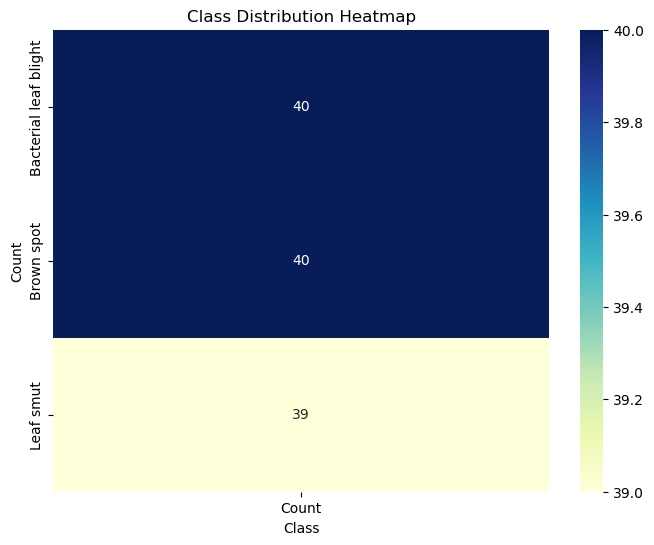

In [6]:

# Convert the class counts dictionary to a DataFrame
df_class_counts = pd.DataFrame(list(class_counts.items()), columns=['Class', 'Count'])

# Reshape the DataFrame for heatmap plotting
heatmap_data = df_class_counts.pivot_table(index='Class', values='Count')

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, cmap='YlGnBu', fmt='d')  # cmap for color map, fmt='d' for integer formatting
plt.title('Class Distribution Heatmap')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()


### Splitting Data into Train, Validation and Test Data

In [7]:
def get_dataset_partitions(dset, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=200):
    assert (train_split + test_split + val_split) == 1
    
    dset_size = len(dset)
    
    if shuffle:
        dset = dset.shuffle(shuffle_size, seed=2)
    
    train_size = int(train_split * dset_size)
    val_size = int(val_split * dset_size)
    
    train_dset = dset.take(train_size)    
    val_dset = dset.skip(train_size).take(val_size)
    test_dset = dset.skip(train_size).skip(val_size)
    
    return train_dset, val_dset, test_dset

In [8]:
train_dset, val_dset, test_dset = get_dataset_partitions(data)

### Cache, Shuffle, and Prefetch the Dataset
Reduces training time, improves hardware utilizaton and shuffle to avoid bias.Caching avoids redundant disk reads, and prefetching hides preprocessing overhead

In [9]:
train_dset = train_dset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_dset = val_dset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dset = test_dset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Building the Model

In [10]:
pip install --upgrade tensorflow

Note: you may need to restart the kernel to use updated packages.


### Rescaling and resizing the images

In [16]:
from tensorflow.keras import layers
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(256,256),
  layers.Rescaling(1./255),
])

### Data Augmentation

In [17]:
# rotating and flipping the images makes the model more robust to variations(angle and orientation variations) and improves performance
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

In [18]:
#inserting the augmented data
train_dset = train_dset.map(lambda x, y: (data_augmentation(x, training=True), y)).prefetch(buffer_size=tf.data.AUTOTUNE)

### Defining Model Architecture

In [20]:
from tensorflow.keras import models
input_shape = (32, 256, 256, 3)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2), # 20% of the entire info dropped to prevent overfitting
    
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

### Model Summary

In [21]:
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_3 (Sequential)            │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (32, 254, 254, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (32, 127, 127, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (32, 127, 127, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (32, 125, 125, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (32, 62, 62, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (32, 62, 62, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (32, 60, 60, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (32, 30, 30, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (32, 30, 30, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (32, 28, 28, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (32, 14, 14, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (32, 14, 14, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (32, 12544)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (32, 64)                    │         802,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (32, 3)                     │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 896,323 (3.42 MB)

 Trainable params: 896,323 (3.42 MB)

 Non-trainable params: 0 (0.00 B)

### Model Compilation

In [22]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

### Model Training

In [25]:
history = model.fit(
    train_dset,
    batch_size=32,
    validation_data=val_dset,
    verbose=1,
    epochs=60,
)

Epoch 1/60
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.3388 - loss: 2.1589 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 2/60


C:\anaconda\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 853ms/step - accuracy: 0.3638 - loss: 1.0924 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/60
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 733ms/step - accuracy: 0.3229 - loss: 1.1015 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 4/60
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 915ms/step - accuracy: 0.3194 - loss: 1.0998 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 5/60
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 751ms/step - accuracy: 0.3344 - loss: 1.0988 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 6/60
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 908ms/step - accuracy: 0.3714 - loss: 1.0969 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 7/60
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 775ms/step - accuracy: 0.3143 - loss: 1.1025 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 8/60
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 771ms/step - accuracy: 0.3299 - loss: 1.0973 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 9/60
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.4380 - loss:

Epoch 51/60
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 809ms/step - accuracy: 0.6594 - loss: 0.7318 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 52/60
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 977ms/step - accuracy: 0.8172 - loss: 0.6265 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 53/60
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 844ms/step - accuracy: 0.7590 - loss: 0.6529 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 54/60
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 827ms/step - accuracy: 0.7212 - loss: 0.7003 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 55/60
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 882ms/step - accuracy: 0.6824 - loss: 0.7167 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 56/60
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 848ms/step - accuracy: 0.7228 - loss: 0.6770 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 57/60
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 864ms/step - accuracy: 0.7762 - loss: 0.6203 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 58/60
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 995ms/step - ac

### Model Evaluation

In [26]:
train_scores = model.evaluate(train_dset)
test_scores = model.evaluate(test_dset)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 278ms/step - accuracy: 0.7212 - loss: 0.7035
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step - accuracy: 0.7500 - loss: 0.6220


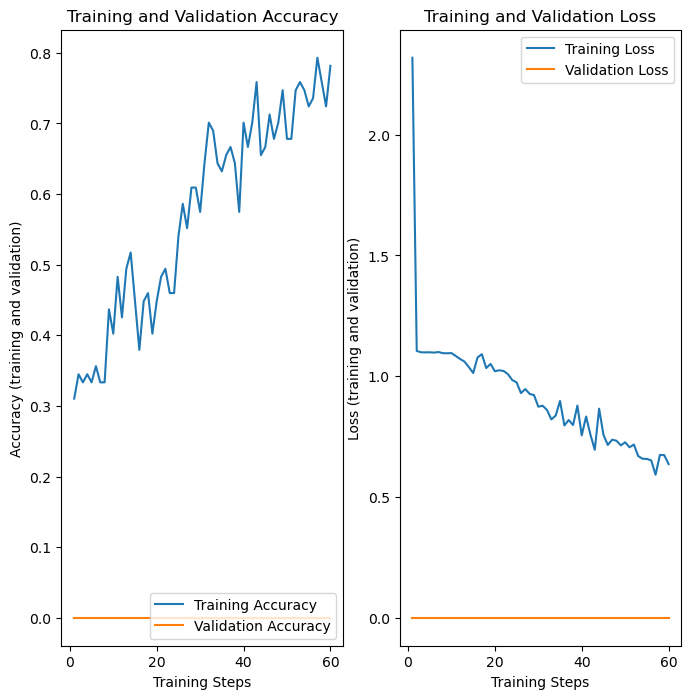

In [34]:
#Plot the Accuracy and Loss Graph to evaluate model performance

import matplotlib.pyplot as plt
import numpy as np

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.show()


From the above, it is observed that the Accuracy increased while the loss decreased indicating a good model.

### Random Image Sampling

first image to predict
actual label: Bacterial leaf blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 507ms/step
predicted label: Bacterial leaf blight
first image to predict
actual label: Leaf smut
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
predicted label: Leaf smut


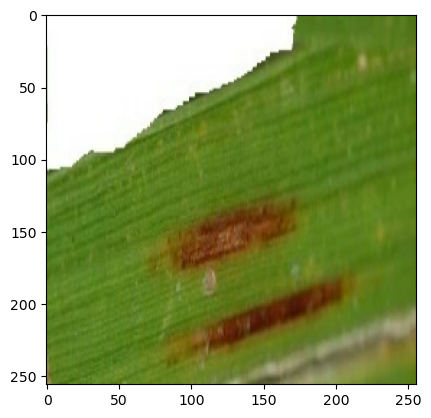

In [37]:
import numpy as np
for images_batch, labels_batch in data.take(2):
    
    first_image = images_batch[19].numpy().astype('uint8')
    first_label = labels_batch[19].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",classes[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",classes[np.argmax(batch_prediction[0])])

In [38]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = classes[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


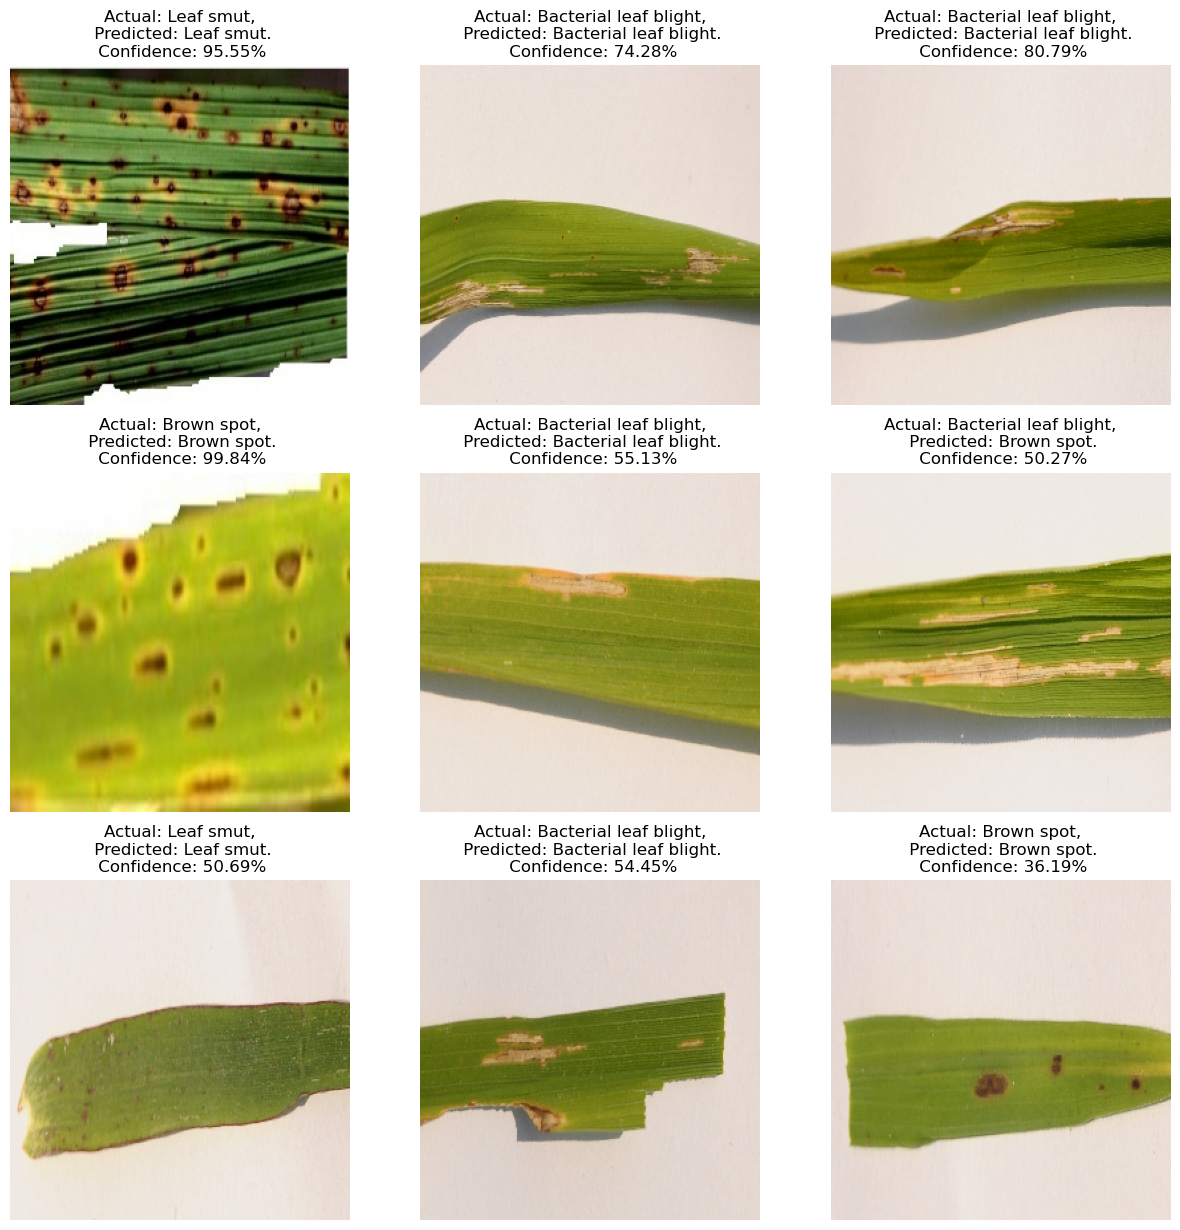

In [39]:
plt.figure(figsize=(15, 15))
for images, labels in data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = classes[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

Challenges Faced:
* The dataset,train and testing was limted
* Limited knowledge on Deep learning algorithms to implement on Image processing
* we were using image shape, array  which  was hard to understand, and it took a certain amount of time to understand the code and implement the data
  when compiling the model, the optimizer, loss and metrics has to be fixed when changed there is an error in the output
* We had a lot of trouble in beginning as we did not have proper updation(installation) of tenserflow and keras because of which we were not able to do anything further for few days.
* There was also a problem related to Sequential while training the model ,solved it by proper updation.

### Conclusion